

Epoch 1/20
18791/18791 [==============================] - 42s 2ms/step - loss: 0.0012 - val_loss: 2.8043e-04
Epoch 2/20
18791/18791 [==============================] - 37s 2ms/step - loss: 0.0010 - val_loss: 2.4201e-04
Epoch 3/20
18791/18791 [==============================] - 44s 2ms/step - loss: 0.0010 - val_loss: 3.5135e-04
Epoch 4/20
18791/18791 [==============================] - 43s 2ms/step - loss: 9.2147e-04 - val_loss: 4.0048e-04
Epoch 5/20
18791/18791 [==============================] - 46s 2ms/step - loss: 8.8929e-04 - val_loss: 4.6325e-04
Epoch 6/20
18791/18791 [==============================] - 44s 2ms/step - loss: 8.1348e-04 - val_loss: 3.4893e-04
Epoch 7/20
18791/18791 [==============================] - 44s 2ms/step - loss: 8.7123e-04 - val_loss: 4.1655e-04
Epoch 8/20
18791/18791 [==============================] - 42s 2ms/step - loss: 8.2760e-04 - val_loss: 3.4469e-04
Epoch 9/20
18791/18791 [==============================] - 42s 2ms/step - loss: 8.0710e-04 - val_loss: 2.52

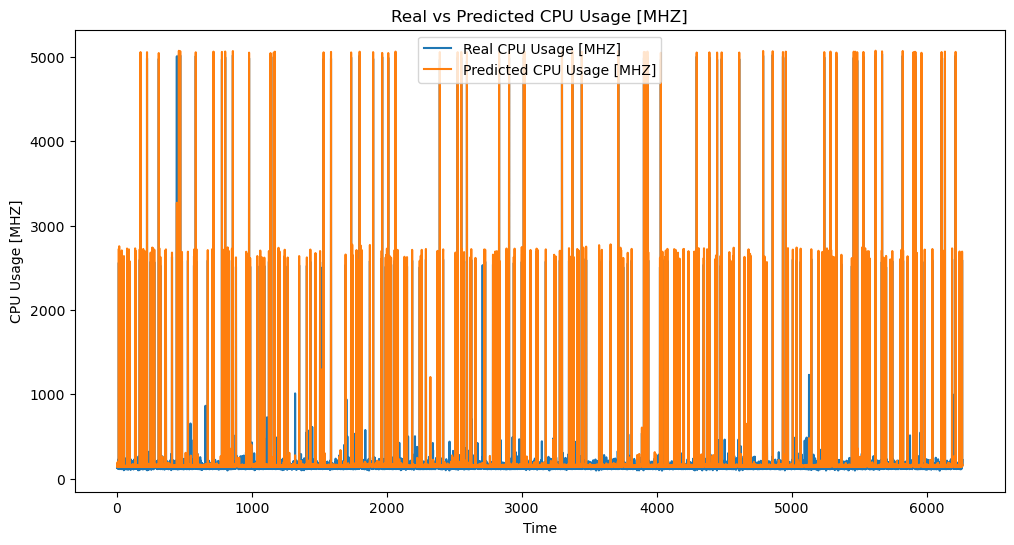

Mean Absolute Percentage Error (MAPE): 15.87%
Precision: 84.13%


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 1
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

Epoch 1/20
18788/18788 [==============================] - 71s 4ms/step - loss: 0.0019 - val_loss: 9.1007e-04
Epoch 2/20
18788/18788 [==============================] - 70s 4ms/step - loss: 0.0012 - val_loss: 9.9355e-04
Epoch 3/20
18788/18788 [==============================] - 70s 4ms/step - loss: 9.8025e-04 - val_loss: 8.8017e-04
Epoch 4/20
18788/18788 [==============================] - 70s 4ms/step - loss: 8.8694e-04 - val_loss: 0.0021
Epoch 5/20
18788/18788 [==============================] - 68s 4ms/step - loss: 8.6228e-04 - val_loss: 7.1305e-04
Epoch 6/20
18788/18788 [==============================] - 67s 4ms/step - loss: 8.2440e-04 - val_loss: 0.0015
Epoch 7/20
18788/18788 [==============================] - 67s 4ms/step - loss: 7.6248e-04 - val_loss: 0.0010
Epoch 8/20
18788/18788 [==============================] - 65s 3ms/step - loss: 7.3138e-04 - val_loss: 5.5968e-04
Epoch 9/20
18788/18788 [==============================] - 64s 3ms/step - loss: 6.5882e-04 - val_loss: 7.3076e-04
Epo

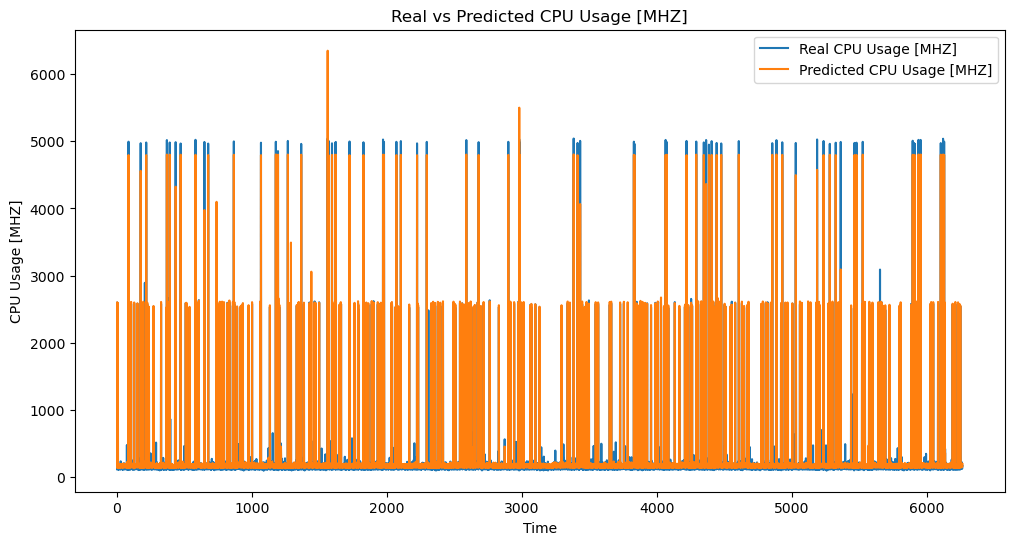

Mean Absolute Percentage Error (MAPE): 17.19%
Precision: 82.81%


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 5
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

Epoch 1/20
18784/18784 [==============================] - 89s 5ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 2/20
18784/18784 [==============================] - 108s 6ms/step - loss: 0.0013 - val_loss: 3.9921e-04
Epoch 3/20
18784/18784 [==============================] - 167s 9ms/step - loss: 0.0011 - val_loss: 2.5987e-04
Epoch 4/20
18784/18784 [==============================] - 167s 9ms/step - loss: 9.7872e-04 - val_loss: 2.6944e-04
Epoch 5/20
18784/18784 [==============================] - 167s 9ms/step - loss: 9.2475e-04 - val_loss: 3.5816e-04
Epoch 6/20
18784/18784 [==============================] - 172s 9ms/step - loss: 9.0778e-04 - val_loss: 2.2953e-04
Epoch 7/20
18784/18784 [==============================] - 166s 9ms/step - loss: 8.4068e-04 - val_loss: 2.4947e-04
Epoch 8/20
18784/18784 [==============================] - 166s 9ms/step - loss: 8.3122e-04 - val_loss: 2.4089e-04
Epoch 9/20
18784/18784 [==============================] - 167s 9ms/step - loss: 8.1720e-04 - val_loss: 2.

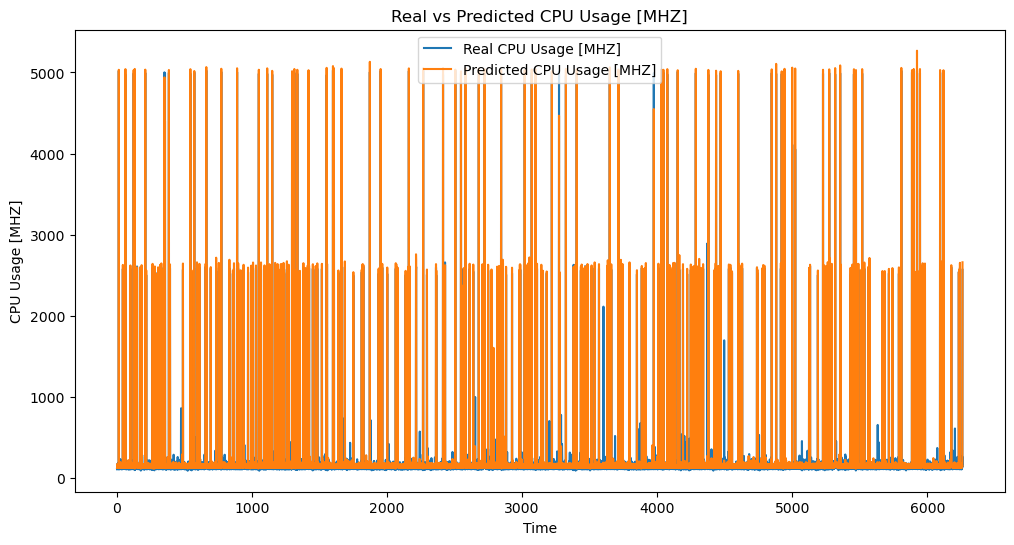

Mean Absolute Percentage Error (MAPE): 11.35%
Precision: 88.65%


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

Epoch 1/20
18784/18784 [==============================] - 155s 8ms/step - loss: 0.0024 - val_loss: 6.2034e-04
Epoch 2/20
18784/18784 [==============================] - 143s 8ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/20
18784/18784 [==============================] - 143s 8ms/step - loss: 0.0014 - val_loss: 5.8405e-04
Epoch 4/20
18784/18784 [==============================] - 143s 8ms/step - loss: 0.0012 - val_loss: 3.8223e-04
Epoch 5/20
18784/18784 [==============================] - 143s 8ms/step - loss: 0.0010 - val_loss: 5.3095e-04
Epoch 6/20
18784/18784 [==============================] - 143s 8ms/step - loss: 0.0010 - val_loss: 3.6526e-04
Epoch 7/20
18784/18784 [==============================] - 143s 8ms/step - loss: 9.2486e-04 - val_loss: 3.6358e-04
Epoch 8/20
18784/18784 [==============================] - 144s 8ms/step - loss: 9.0494e-04 - val_loss: 9.3132e-04
Epoch 9/20
18784/18784 [==============================] - 143s 8ms/step - loss: 9.2179e-04 - val_loss: 3.9012e-04
Ep

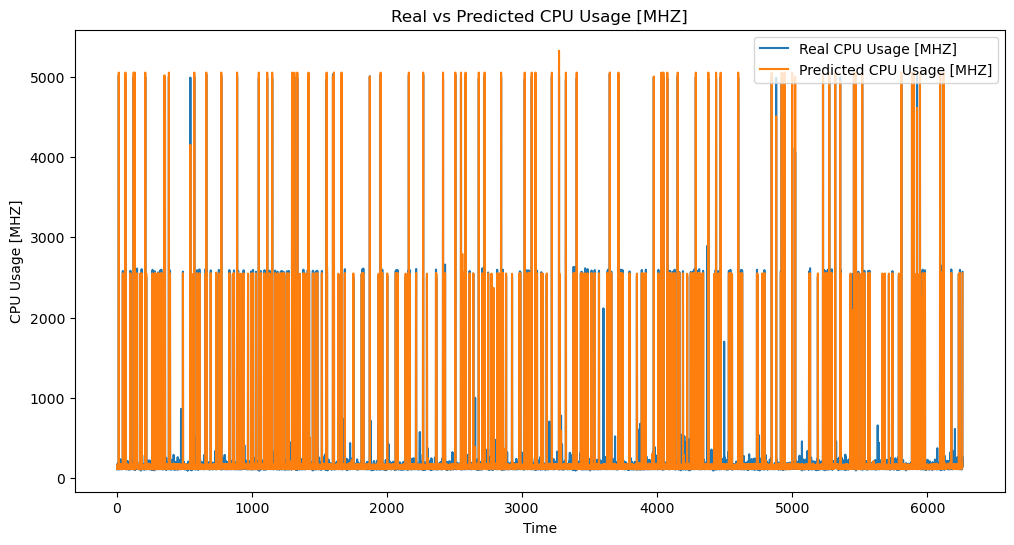

Mean Absolute Percentage Error (MAPE): 8.82%
Precision: 91.18%


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

Epoch 1/20
1174/1174 [==============================] - 15s 10ms/step - loss: 0.0025 - val_loss: 7.0476e-04
Epoch 2/20
1174/1174 [==============================] - 10s 9ms/step - loss: 0.0015 - val_loss: 3.3047e-04
Epoch 3/20
1174/1174 [==============================] - 11s 9ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/20
1174/1174 [==============================] - 10s 9ms/step - loss: 0.0011 - val_loss: 2.9547e-04
Epoch 5/20
1174/1174 [==============================] - 10s 9ms/step - loss: 9.0730e-04 - val_loss: 2.7283e-04
Epoch 6/20
1174/1174 [==============================] - 11s 9ms/step - loss: 9.6618e-04 - val_loss: 3.0391e-04
Epoch 7/20
1174/1174 [==============================] - 10s 9ms/step - loss: 9.0293e-04 - val_loss: 2.8614e-04
Epoch 8/20
1174/1174 [==============================] - 10s 9ms/step - loss: 8.8610e-04 - val_loss: 2.9274e-04
Epoch 9/20
1174/1174 [==============================] - 10s 9ms/step - loss: 8.1062e-04 - val_loss: 6.2162e-04
Epoch 10/20
1174/117

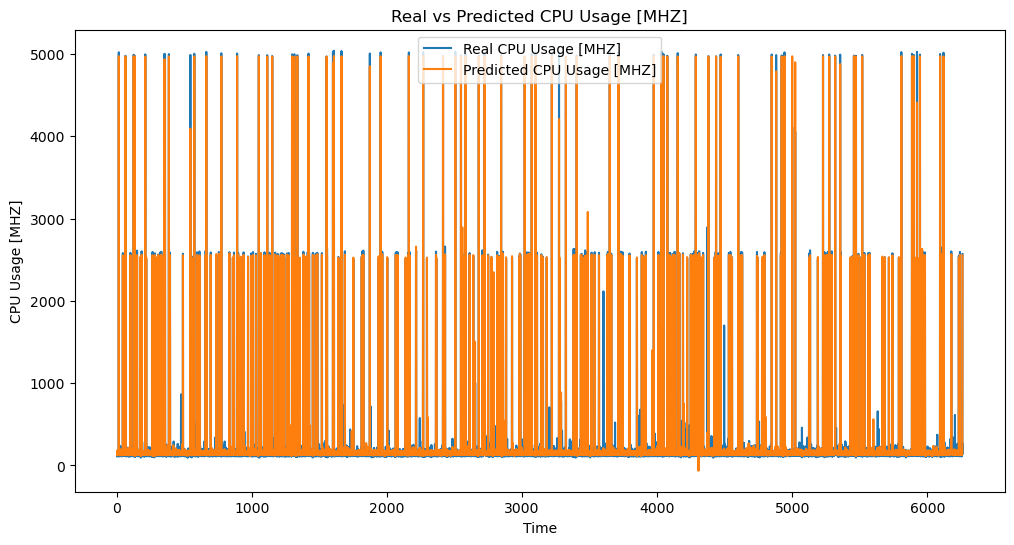

Mean Absolute Percentage Error (MAPE): 11.57%
Precision: 88.43%


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

combined_df.head()

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Define cross-validation parameters
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store results
mape_list = []
precision_list = []

# Cross-validation loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM Model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the Model
    model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test), verbose=1)

    # Evaluate the Model
    predictions = model.predict(X_test)

    # Rescale predictions back to original scale using the correct scaler
    y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
    predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100
    mape_list.append(mape)

    # Calculate precision as 100 - MAPE
    precision = 100 - mape
    precision_list.append(precision)

# Calculate average MAPE and precision over all folds
average_mape = np.mean(mape_list)
average_precision = np.mean(precision_list)

print(f'Average Mean Absolute Percentage Error (MAPE): {average_mape:.2f}%')
print(f'Average Precision: {average_precision:.2f}%')



Epoch 1/20
1174/1174 [==============================] - 28s 19ms/step - loss: 0.0024 - val_loss: 5.3639e-04
Epoch 2/20
1174/1174 [==============================] - 22s 19ms/step - loss: 0.0014 - val_loss: 4.7289e-04
Epoch 3/20
1174/1174 [==============================] - 23s 19ms/step - loss: 0.0010 - val_loss: 2.7618e-04
Epoch 4/20
1174/1174 [==============================] - 27s 23ms/step - loss: 9.2745e-04 - val_loss: 2.3379e-04
Epoch 5/20
1174/1174 [==============================] - 28s 24ms/step - loss: 9.5368e-04 - val_loss: 2.2041e-04
Epoch 6/20
1174/1174 [==============================] - 29s 25ms/step - loss: 8.6033e-04 - val_loss: 2.1359e-04
Epoch 7/20
1174/1174 [==============================] - 29s 24ms/step - loss: 9.6199e-04 - val_loss: 2.6485e-04
Epoch 8/20
1174/1174 [==============================] - 29s 25ms/step - loss: 8.8019e-04 - val_loss: 4.8759e-04
Epoch 9/20
1174/1174 [==============================] - 26s 22ms/step - loss: 8.7827e-04 - val_loss: 2.8515e-04
Ep

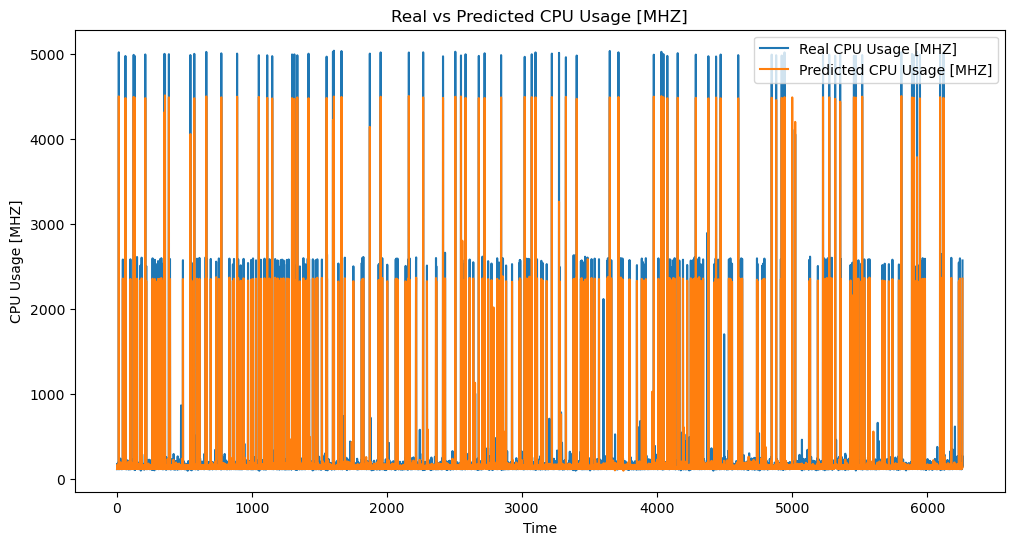

Mean Absolute Percentage Error (MAPE): 11.39%
Precision: 88.61%
261/261 [==============================] - 3s 10ms/step
   Real CPU Usage [MHZ]  Predicted CPU Usage [MHZ]
0                  89.0                 116.842155
1                  78.0                 115.684517
2                  86.0                 115.591820
3                  96.0                 115.011520
4                  87.0                 114.934471


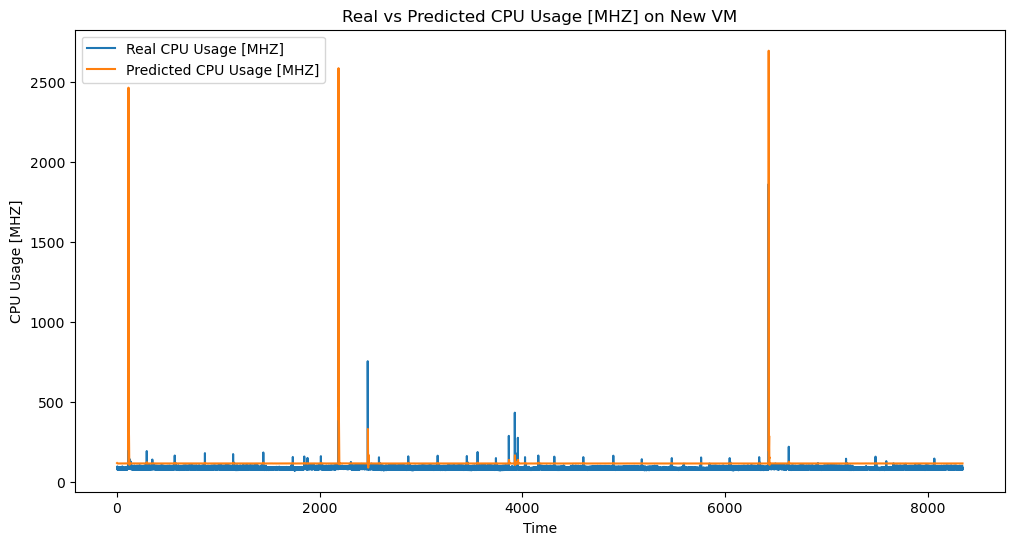

Mean Absolute Percentage Error (MAPE) on New VM: 38.38%
Precision on New VM: 61.62%


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to create sequences for LSTM model
def create_sequences(data, target, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data.iloc[i:(i + time_steps)].values)
        ys.append(target.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load the CSV files
df1 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/01.csv', delimiter=';')
df2 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/02.csv', delimiter=';')
df3 = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/03.csv', delimiter=';')

# Add VM identifier to each dataframe
df1['VM'] = 'VM1'
df2['VM'] = 'VM2'
df3['VM'] = 'VM3'

# Combine the dataframes
combined_df = pd.concat([df1, df2, df3])

# Replace commas with dots and convert to numeric
combined_df['CPU usage [%]'] = combined_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the Data
cpu_mhz_scaler = MinMaxScaler()
cpu_percent_scaler = MinMaxScaler()

combined_df['CPU usage [MHZ]'] = cpu_mhz_scaler.fit_transform(combined_df[['CPU usage [MHZ]']])
combined_df['CPU usage [%]'] = cpu_percent_scaler.fit_transform(combined_df[['CPU usage [%]']])

# Define features and target
features = ['CPU usage [MHZ]', 'CPU usage [%]']
target = 'CPU usage [MHZ]'

# Create sequences
time_steps = 10
X, y = create_sequences(combined_df[features], combined_df[target], time_steps)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Build the LSTM Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate the Model
predictions = model.predict(X_test)

# Rescale predictions back to original scale using the correct scaler
y_test_scaled = cpu_mhz_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_scaled = cpu_mhz_scaler.inverse_transform(predictions)

# Debugging: Print shapes of arrays
print(f'Shape of y_test_scaled: {y_test_scaled.shape}')
print(f'Shape of predictions_scaled: {predictions_scaled.shape}')

# Ensure lengths match before creating DataFrame
if len(y_test_scaled) == len(predictions_scaled):
    # Create a DataFrame for comparison
    comparison_df = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_test_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df.to_csv('comparison.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ]')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_test_scaled.flatten() - predictions_scaled.flatten()) / y_test_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision = 100 - mape

    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Precision: {precision:.2f}%')
else:
    print("Error: Lengths of y_test_scaled and predictions_scaled do not match.")

# Load the new dataset
new_df = pd.read_csv('GWA-T13-materna-trace/Materna-Trace-1/04.csv', delimiter=';')

# Replace commas with dots and convert to numeric
new_df['CPU usage [%]'] = new_df['CPU usage [%]'].str.replace(',', '.').astype(float)

# Normalize the new dataset
new_df['CPU usage [MHZ]'] = cpu_mhz_scaler.transform(new_df[['CPU usage [MHZ]']])
new_df['CPU usage [%]'] = cpu_percent_scaler.transform(new_df[['CPU usage [%]']])

# Create sequences for the new dataset
X_new, y_new = create_sequences(new_df[features], new_df[target], time_steps)

# Make predictions on the new dataset
predictions_new = model.predict(X_new)

# Rescale predictions back to original scale
y_new_scaled = cpu_mhz_scaler.inverse_transform(y_new.reshape(-1, 1))
predictions_new_scaled = cpu_mhz_scaler.inverse_transform(predictions_new)

# Ensure lengths match before creating DataFrame
if len(y_new_scaled) == len(predictions_new_scaled):
    # Create a DataFrame for comparison
    comparison_df_new = pd.DataFrame({
        'Real CPU Usage [MHZ]': y_new_scaled.flatten(),
        'Predicted CPU Usage [MHZ]': predictions_new_scaled.flatten()
    })

    # Display the first few rows of the DataFrame
    print(comparison_df_new.head())

    # Save the DataFrame to a CSV file for further inspection if needed
    comparison_df_new.to_csv('comparison_new.csv', index=False)

    # Plot Real vs Predicted Values
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df_new['Real CPU Usage [MHZ]'], label='Real CPU Usage [MHZ]')
    plt.plot(comparison_df_new['Predicted CPU Usage [MHZ]'], label='Predicted CPU Usage [MHZ]')
    plt.title('Real vs Predicted CPU Usage [MHZ] on New VM')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage [MHZ]')
    plt.legend()
    plt.show()

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_new = np.mean(np.abs((y_new_scaled.flatten() - predictions_new_scaled.flatten()) / y_new_scaled.flatten())) * 100

    # Calculate precision as 100 - MAPE
    precision_new = 100 - mape_new

    print(f'Mean Absolute Percentage Error (MAPE) on New VM: {mape_new:.2f}%')
    print(f'Precision on New VM: {precision_new:.2f}%')
else:
    print("Error: Lengths of y_new_scaled and predictions_new_scaled do not match.")